# Engineering Serendipity in Music Recommendation with NLP

Thomas Nuttall - 2019

https://gitlab.com/tnutz/mard_recommendations

Here we use LDA Topic Modelling to identify k distinct patterns in album reviews. We use these patterns to define our albums as distributions over this higher level abstraction. Distribution similarity is used for recommendation.

In [96]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random_state = 42

In [97]:
import collections
import gensim
import multiprocessing
import pandas as pd
import sys
sys.path.append('../code/')

import evaluation
import feature_extraction
import model
import persistence
import utils

logger = utils.get_logger('__main__')

### 1. Data Load

We load the MARD review dataset - https://www.upf.edu/web/mtg/mard

In [33]:
review_path = "../data/mard_reviews.json"

In [34]:
metadata = pd.read_json('../data/mard_metadata.json', lines=True)

In [113]:
orig_data = persistence.load_data(review_path)

[2019-03-17 15:21:09,764] INFO [__main__.load_data:23] Loading review data from ../data/mard_reviews.json
[2019-03-17 15:21:15,725] INFO [__main__.load_data:33] 263525 reviews of 64637 albums by 187090 reviewers


Obtain list of heavily reviewed albums

In [114]:
min_reviews = 1
heavily_reviewed_ids = [
    k for k,v in dict(collections.Counter(orig_data['amazon-id'])).items()\
    if v >= min_reviews
]

We group all reviews of the same album to one concatenated daddy review

In [16]:
data = persistence.combine_reviews(orig_data)

[2019-03-17 13:51:02,131] INFO [__main__.combine_reviews:14] Combined 263525 reviews to 64637


### 2. Data Preparation

In [17]:
fraction_of_data = 0.5
#data_sample = data.sample(n=int(fraction_of_data*len(data)))
#data_sample = data[data['amazon-id'].isin(heavily_reviewed_ids)]
data_sample = data

##### 2.2 Parse Review
Here we extract from our review paragraph a list of words used, transformations applied:

- Remove apostrophes
- Force to lower case
- Remove stopwords (see: https://en.wikipedia.org/wiki/Stop_words)
- Remove words that are less than 3 characters long
- Remove words that don't exist

In [18]:
word_reviews = feature_extraction.parse_reviews(data_sample.values)

[2019-03-17 13:51:02,217] INFO [__main__.parse_reviews:32] Parsing reviews and extracting meaningful words
[2019-03-17 13:51:15,570] INFO [__main__.parse_reviews:40] Total number of unique words in corpus 23889
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-10:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-5:
Process ForkPoolWorker-12:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/process.py", line 

  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/connect

##### 2.3 Identify Wordgrams
A bigram and trigram model is applied to group words that commonly occur together. This maintains some relationship between neighbouring words, otherwise lost with our bag of words model. Examples include:
- soothes soul -> soothes_soul
- highly recomended -> highly_recommended
- tai chi -> tai_chi

In [19]:
word_grams = feature_extraction.apply_gram_models(word_reviews)

[2019-03-17 13:51:15,675] INFO [__main__.apply_gram_models:82] Training bigram and trigram models


##### 2.4 Get Lemmas
We transform all words to their lemmas were neccesary, lemmatization converts a word to its root word, for example:
- beats -> beat
- wobbling –> wobble

In [20]:
word_lemmas = feature_extraction.lemmatization(word_grams)

Process ForkPoolWorker-23:
Process ForkPoolWorker-18:
Process ForkPoolWorker-16:
Process ForkPoolWorker-19:
Process ForkPoolWorker-15:
Process ForkPoolWorker-22:
Process ForkPoolWorker-24:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-13:
Process ForkPoolWorker-21:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    self.run()
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/process.py", line 254, in _bootstrap
    sel

KeyboardInterrupt
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/tom/.pyenv/versions/3.5.1/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


##### 2.5 Get Training Corpus
Gensim LDA expects a Corpus object and a dictionary, which basically indicizes all words and reviews so the model deals with numbers only.

In [21]:
amazon_ids, gen_dict, corpus = feature_extraction.get_dict_and_corpus(word_lemmas)

In [22]:
[[(gen_dict[i], freq) for i, freq in cp][:7] for cp in corpus[29:30]]

[[('really', 1), ('hear', 1), ('care', 1), ('arch', 1)]]

### 3. Modelling

Save what you have from the previous section:

In [ ]:
persistence.pickle_object('PATH HERE', corpus)
persistence.pickle_object('PATH HERE', amazon_ids)
persistence.gen_dict.save('PATH HERE')

##### 3.1 LDA Topic Modelling

LDA for abstract latent representation of documents. You have three options (do not run all):
- 3.1.1 Train single LDA model
- 3.1.2 Train multiple on various values of k, storing results in experiment dataframe
- 3.1.3 Load existing model

In [723]:
from sklearn.model_selection import train_test_split
from uuid import uuid4
import matplotlib.pyplot as plt1
import numpy as np

In [25]:
train, test = train_test_split(corpus, test_size=0.2, random_state=random_state)

##### 3.1.1 Train one model

In [27]:
lda_model = gensim.models.ldamulticore.LdaMulticore(
                           corpus=corpus,
                           id2word=gen_dict,
                           num_topics=150,
                           random_state=random_state,
                           workers=5,
                           passes=20,
                           iterations=1500,
                           per_word_topics=True
                    )

run_id = str(uuid4())
print(run_id)
lda_model.save('../models/{}'.format(run_id))

7ab327b0-6059-49e5-817a-32f727018401


##### 3.1.2 Train at multiple values of k here

In [ ]:
experiment_frame = pd.DataFrame({
    'run_id':[],
    'k':[],
    'log_perplexity':[]
})

In [92]:
all_k = [10, 30, 50, 75, 100, 150, 200, 250]

for k in all_k:
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                               corpus=train,
                               id2word=gen_dict,
                               num_topics=k, 
                               random_state=random_state,
                               workers=5,
                               passes=20,
                               iterations=1000,
                               per_word_topics=True
                        )
    
    run_id = str(uuid4())
    
    log_perplexity = ldaA_model.log_perplexity(test)
    
    print('{}, {}, {}'.format(run_id, k, log_perplexity))
    
    experiment_frame.append({'run_id':run_id, 'k':k, 'log_perplexity':log_perplexity}, ignore_index=True)
    
    lda_model.save('../models/{}'.format(run_id))
    
experiment_frame.to_csv('results.csv')

aeb194e9-7e7d-4747-9ebb-e3d6f868f3ad, 10, -7.899313387696005
c2d23298-47e5-4241-9cb3-4086622f2b55, 30, -8.222576361396289
1838233b-e3d7-4961-bde1-7f36264e2170, 50, -8.452632219538383
e6709e29-3402-4a27-b38d-ee0821a1fbde, 75, -8.761166800280128
2104ffc6-19e0-48c7-aebb-acb470fea8ca, 100, -9.00465955207911
ca71f1fd-82ff-4869-9294-db93a67af313, 150, -9.444162602416672
9ba181c0-7500-4abc-9c6d-0155fa2e86d7, 200, -9.977104155499253
c0b7327a-9f96-43e3-a824-dba77e54179b, 250, -10.644037659425582


Examine log perplexity for an obvious choice of k

Text(0.5,1,'Experiment Results')

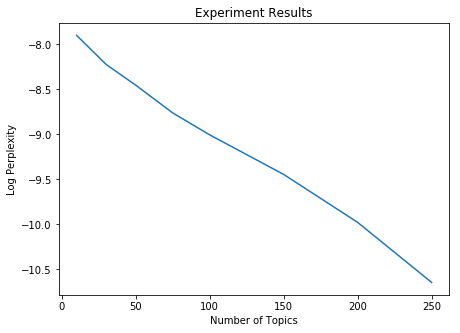

In [121]:
plt.figure(figsize=(7,5))
plt.plot(experiment_frame['k'], experiment_frame['log_perplexity'])
plt.xlabel('Number of Topics')
plt.ylabel('Log Perplexity')
plt.title('Experiment Results')

##### 3.1.3 Load here

In [ ]:
lda_model, gen_dict, corpus, amazon_ids = persistence.load_folder('../production_model')

With a model from one of the above methods you can plot the topics here.

In [77]:
i = 0

Repeatedly run this cell to iterate through topics

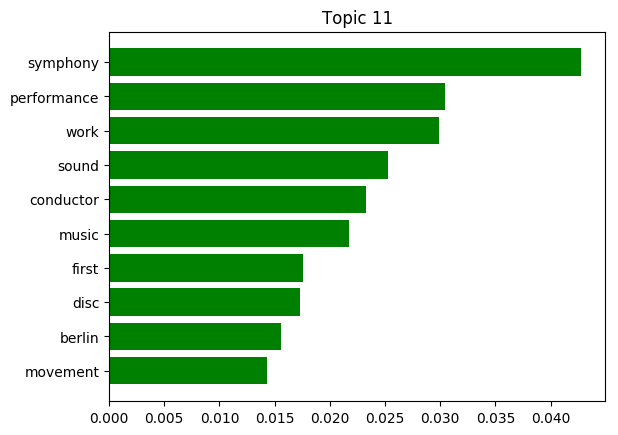

In [89]:
utils.plot_topics(lda_model, i)
i += 1

Predict the topic distribution of our documents

In [12]:
prediction = model.predict_topic_distribution(lda_model, corpus)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 6. Recommendation

In [1]:
from sklearn.metrics.pairwise import pairwise_kernels

LDA model output a probability distribution across features for each album. We use cosine similarity between these distributions to compute similarity.

In [29]:
LDA_sim = pairwise_kernels(prediction, metric='cosine', n_jobs=5)
LDA_sim.shape

(64531, 64531)

Let's try with an example 

In [865]:
artist = 'coltrane' # substring of artist you wish to get recommendations for
model.get_rec_from_substring(artist, metadata, LDA_sim, amazon_ids)

Top Recommendations for John Coltrane - 1960 Dusseldorf [Jazz]:

Stage Stars Records - Fiddler on the Roof  [Pop]
Cabin in the Sky - Cabin in the Sky  [Pop]
Various Artists - You Can't Put Ketchup on the Moon  [Jazz]
Ryan Ramirez - Regions [New Age]
Sian Phillips - A Little Night Music  [Pop]


### 7. Recommender Evaluation

We evaluate our recommender by AB testing it with a chance model. For a given track, two recommendations are presented, one is from our recommender, one is chosen at random, the viewer does not know which is which. The viewer must chose which is better, a point is added to each recommenders score everytime it wins an iteration.

In [853]:
chance = 0
our_model = 0

In [855]:
chance, our_model = evaluation.chance_deathmatch(metadata, LDA_sim, amazon_ids, chance, our_model)

Recommendations for The Cold - Three Chord City [Metal]:

Recommender A:
Camilo Sesto - Camilo Sestos-Algo Mas [Latin Music]
Roy Milton - Miltone Records [R&B]
Valencia Vas - Reflections [Latin Music]
Third Ear Band - Alchemy [Rock]
Love Seed Mama Jump - Summer Of Love [Alternative Rock]


Recommender B:
Robbin Thompson - Two B's Please [Rock]
Larry Stewart - Heart Like A Hurricane [Country]
Kekal - Acidity [Metal]
Eduardo Cruz - Cosas Que Contar [Latin Music]
Pagans - Everybody Hates You [Alternative Rock]


['Which recommender is best, a or b? (or p to pass)']p


In [845]:
evaluation.bayesian_test(25, 78, 78, 25)

0.9999999999999826

In [6]:
import numpy as np

In [8]:
np.std([5]*10 + [4]*10 + [3]*20 + [2]*20 + [1]*30)

1.3425606637327305

In [ ]:
2.2